## Imports & Constants

In [3]:
from sklearn.metrics import recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import warnings

In [4]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RSEED = 12345
COUNTER_TYPE_MAPPING = {"ELEC": 0, "GAZ": 1}
MAX_FEATURES_PER_ROW = 6

def evaluate_model(y_true, y_predict, y_predict_proba):
    cm = confusion_matrix(y_true, y_predict)
    plt.figure()
    sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="copper")
    print(f"F1: {f1_score(y_true, y_predict):.2f}")
    print(f"Recall: {recall_score(y_true, y_predict):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_predict_proba):.2f}")

def train_and_predict(classifier, X_train, y_train, X_test, y_test):    
    classifier.fit(X_train, y_train)
    print("TRAIN:")
    evaluate_model(y_train, classifier.predict(X_train), classifier.predict_proba(X_train)[:,1])
    print("\nTEST:")
    evaluate_model(y_test, classifier.predict(X_test), classifier.predict_proba(X_test)[:,1])

## Client and Invoice data

In [5]:
df_clients = pd.read_csv("data/train/client_train.csv")
df_invoices = pd.read_csv("data/train/invoice_train.csv")

### Client data

In [6]:
df_clients.info()
display(df_clients.isnull().sum())
display(df_clients)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


### Invoice data

In [7]:
df_invoices.info()
display(df_invoices.isnull().sum())
display(df_invoices)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


## Data Cleaning & Feature Engineering

In [8]:
# Split up invoice_date
invoice_date = pd.to_datetime(df_invoices["invoice_date"], format="%Y-%m-%d")
df_invoices["invoice_date"] = (invoice_date.astype(int) / 10**9).astype(int)
df_invoices["invoice_year"] = invoice_date.dt.year
df_invoices["invoice_month"] = invoice_date.dt.month

# Derive consumption from old and new counter indices
df_invoices["consumption"] = df_invoices["new_index"] - df_invoices["old_index"]

# Sanitize counter type and status
df_invoices["counter_type"] = df_invoices["counter_type"].map(COUNTER_TYPE_MAPPING).astype(int)
df_invoices["counter_statue"] = df_invoices["counter_statue"].replace("A", 10).astype(int)

# Split up account creation date
creation_date = pd.to_datetime(df_clients["creation_date"], format="%d/%m/%Y")
df_clients["creation_date"] = (creation_date.astype(int) / 10**9).astype(int)
df_clients["creation_year"] = creation_date.dt.year
df_clients["creation_month"] = creation_date.dt.month

# Convert target from float to int
df_clients["target"] = df_clients["target"].astype(int)

"""
agg_trans = df_invoices.groupby(['client_id']).agg(
    consommation_level_1=("consommation_level_1", "mean"),
    consommation_level_2=("consommation_level_2", "mean"),
    consommation_level_3=("consommation_level_3", "mean"),
    consommation_level_4=("consommation_level_4", "mean"),
    consumption=("consumption", "mean")
)
df = pd.merge(df_clients, agg_trans, on='client_id', how='left')
df = pd.merge(df, df_invoices.groupby('client_id').size().reset_index(name="transactions_count"))
"""

df = df_invoices.merge(df_clients, on="client_id", how="left")
# Remove client_id
df = df.drop(["client_id"], axis=1)
# Remove all rows for year < 2005, because there was no fraud detection
df = df.drop(df[df["invoice_year"] < 2005].index)

### The resulting dataset

In [9]:
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 4454637 entries, 0 to 4476745
Data columns (total 25 columns):
 #   Column                Dtype
---  ------                -----
 0   invoice_date          int64
 1   tarif_type            int64
 2   counter_number        int64
 3   counter_statue        int64
 4   counter_code          int64
 5   reading_remarque      int64
 6   counter_coefficient   int64
 7   consommation_level_1  int64
 8   consommation_level_2  int64
 9   consommation_level_3  int64
 10  consommation_level_4  int64
 11  old_index             int64
 12  new_index             int64
 13  months_number         int64
 14  counter_type          int64
 15  invoice_year          int32
 16  invoice_month         int32
 17  consumption           int64
 18  disrict               int64
 19  client_catg           int64
 20  region                int64
 21  creation_date         int64
 22  target                int64
 23  creation_year         int32
 24  creation_month        int32
d

,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,invoice_year,invoice_month,consumption,disrict,client_catg,region,creation_date,target,creation_year,creation_month
0,1395619200,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,2014,3,82,60,11,101,788832000,0,1994,12
1,1364515200,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,2013,3,1384,60,11,101,788832000,0,1994,12
2,1427068800,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,2015,3,123,60,11,101,788832000,0,1994,12
3,1436745600,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,2015,7,102,60,11,101,788832000,0,1994,12
4,1479340800,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,2016,11,572,60,11,101,788832000,0,1994,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476741,1392595200,40,0,0,5,9,1,118,0,0,0,406,524,4,1,2014,2,118,63,11,311,1321920000,0,2011,11
4476742,1402617600,11,262195,0,207,9,1,312,0,0,0,2562,2874,4,0,2014,6,312,63,11,311,1321920000,0,2011,11
4476743,1572998400,11,262195,0,207,9,1,578,0,0,0,8505,9083,4,0,2019,11,578,63,11,311,1321920000,0,2011,11
4476744,1124409600,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,0,2005,8,535,60,11,101,756518400,0,1993,12


## EDA

### Unique values

In [10]:
for col in df.columns.sort_values():
    print(f"{col}: {np.sort(df[col].unique())}")

client_catg: [11 12 51]
consommation_level_1: [     0      1      2 ...  98889 126118 999910]
consommation_level_2: [     0      1      2 ... 785757 819886 999073]
consommation_level_3: [    0     1     2 ... 45360 50695 64492]
consommation_level_4: [     0      1      2 ... 284765 343568 547946]
consumption: [-999025 -998916 -998539 ...  625521  629631  633228]
counter_code: [  0   1   5  10  16  25  40  65 101 102 201 202 203 204 207 210 214 222
 227 303 305 307 403 407 410 413 420 433 442 450 453 467 483 506 532 565
 600]
counter_coefficient: [ 0  1  2  3  4  5  6  8  9 10 11 20 30 33 40]
counter_number: [             0              1              2 ... 27391100365417
 27553463395500 27981145458733]
counter_statue: [  0   1   2   3   4   5  10  46 420 618 769]
counter_type: [0 1]
creation_date: [ 223948800  224294400  224380800 ... 1566345600 1567641600 1568073600]
creation_month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
creation_year: [1977 1978 1979 1980 1981 1982 1983 1984 1985 1986

### Feature boxplots

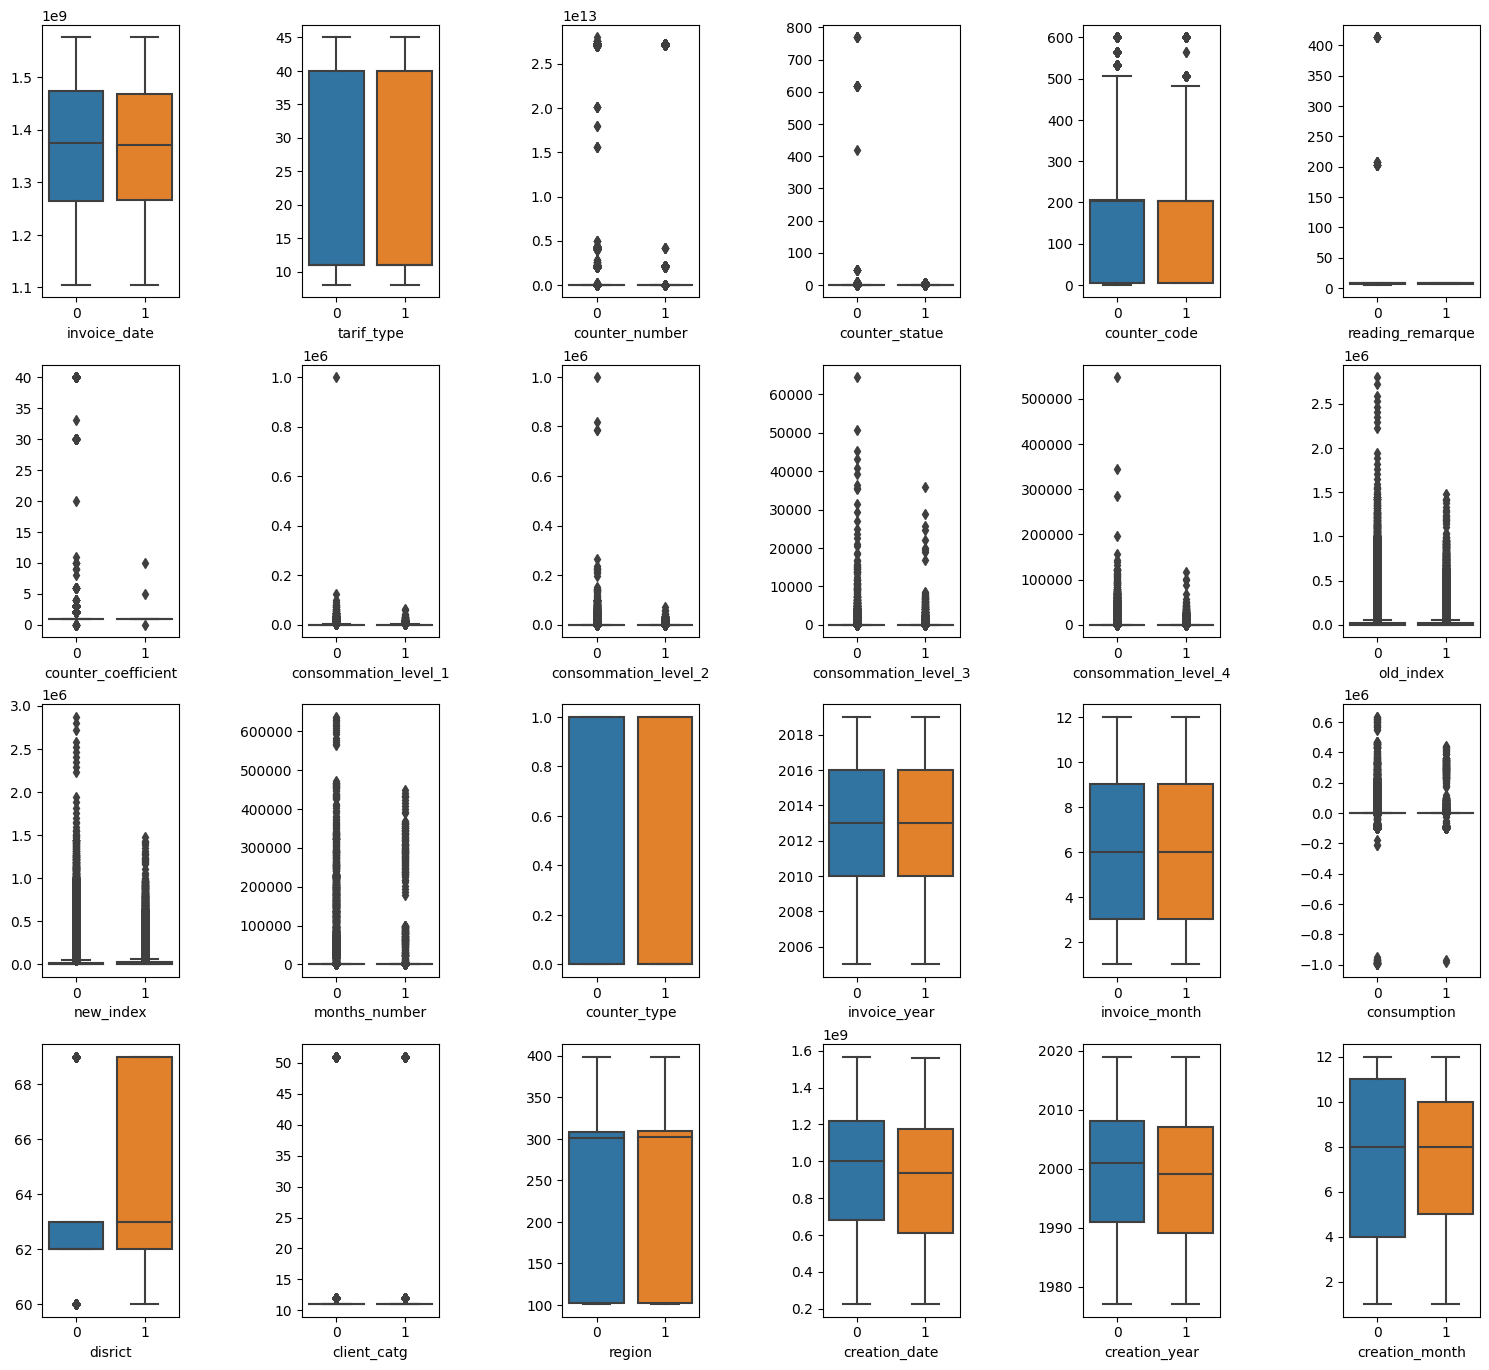

In [11]:
cols = df.columns.drop("target")
nrows = math.ceil(len(cols)/MAX_FEATURES_PER_ROW)
fig, ax = plt.subplots(nrows, MAX_FEATURES_PER_ROW, figsize = (15,15))

for i,col in enumerate(cols):
    nrow = math.floor(i/MAX_FEATURES_PER_ROW)
    ncol = i%MAX_FEATURES_PER_ROW
    f = sns.boxplot(y=df[col], x=df["target"], ax=ax[nrow][ncol])
    f.set_xlabel(col)
    f.set_ylabel(None)

fig.tight_layout()
plt.subplots_adjust(wspace = 0.9, top = 0.9)
plt.show()

### Correlations

<Axes: >

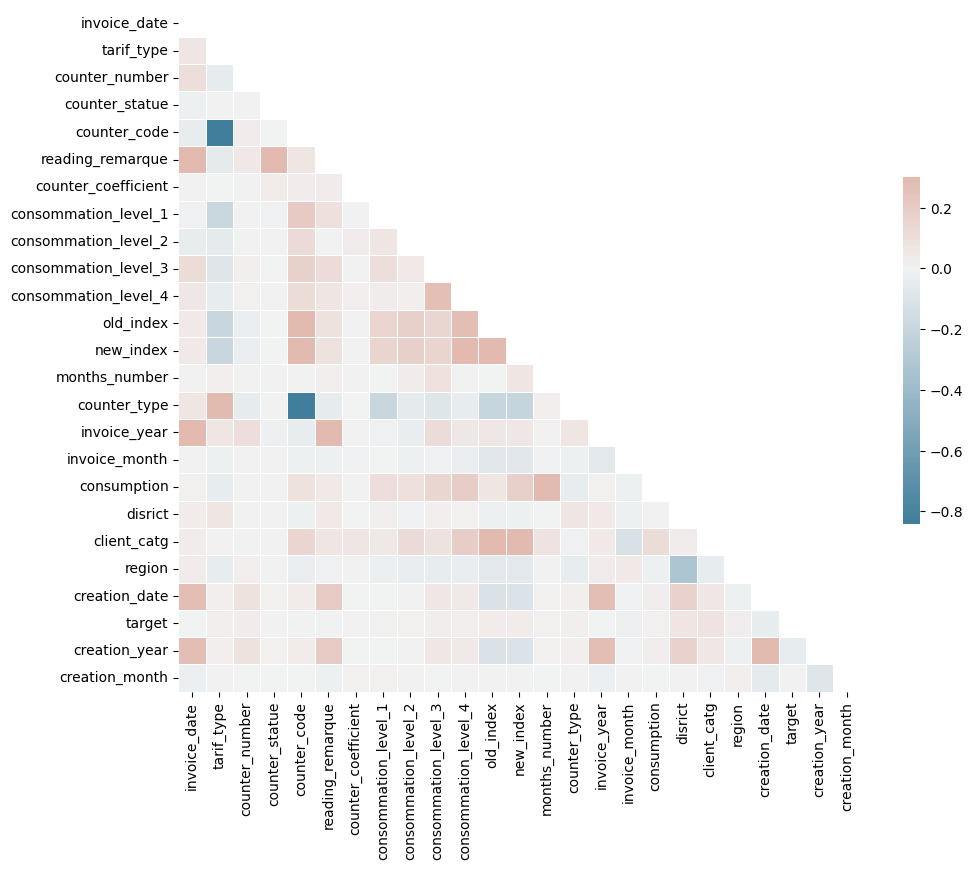

In [12]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Splitting the data

In [13]:
#df = pd.get_dummies(drop_first=True, data=df, columns=["disrict", "region", "client_catg", "tarif_type", "reading_remarque",
#							 "counter_type", "counter_code", "counter_statue", "counter_coefficient"])

y = df["target"]
X = df.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = RSEED)

## Modeling

### Baseline model: Coin toss

F1: 0.14
Recall: 0.50
ROC-AUC: 0.50


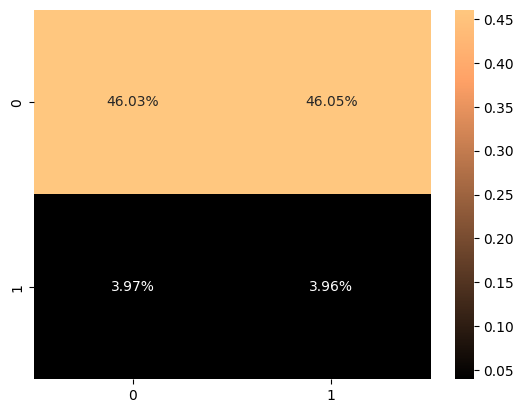

In [14]:
y_pred = np.random.randint(2, size=len(df))
evaluate_model(y, y_pred, y_pred)

### Random Forest with 100 estimators

TRAIN:
F1: 1.00
Recall: 1.00
ROC-AUC: 1.00

TEST:
F1: 0.55
Recall: 0.39
ROC-AUC: 0.98


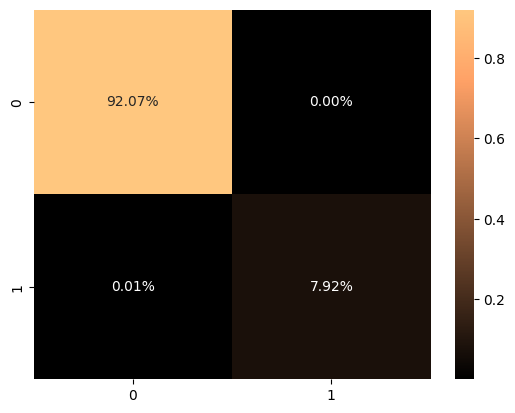

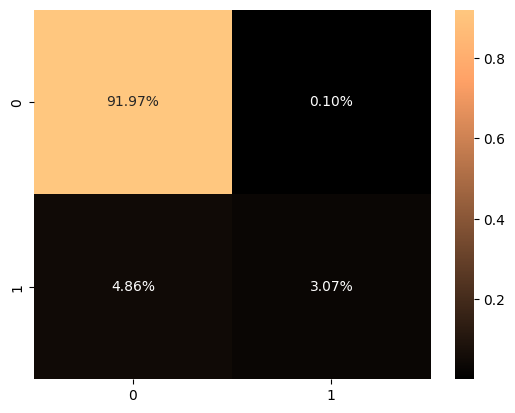

In [15]:
train_and_predict(RandomForestClassifier(n_estimators=100, random_state=RSEED, n_jobs=-1), X_train, y_train, X_test, y_test)

### Single Decision Tree

TRAIN:
F1: 1.00
Recall: 1.00
ROC-AUC: 1.00

TEST:
F1: 0.88
Recall: 0.88
ROC-AUC: 0.93


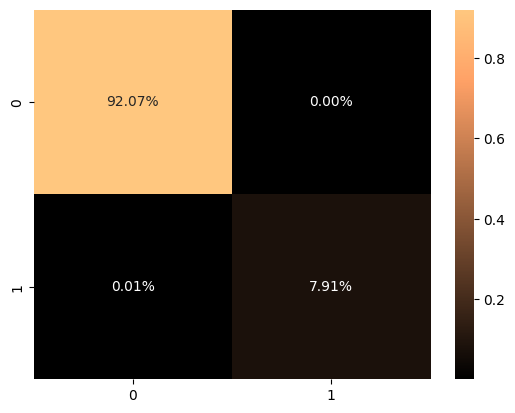

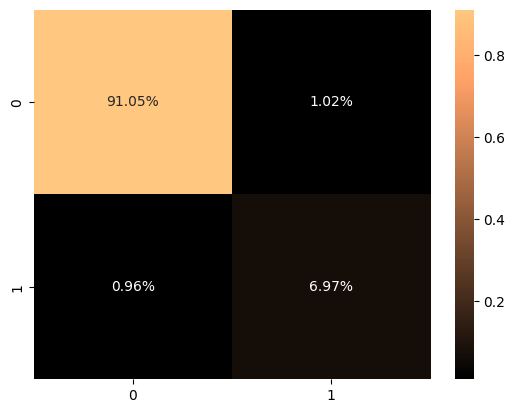

In [16]:
train_and_predict(DecisionTreeClassifier(random_state=RSEED), X_train, y_train, X_test, y_test)

### KNN

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
train_and_predict(KNeighborsClassifier(n_neighbors=5, n_jobs=-1), scaler.transform(X_train), y_train, scaler.transform(X_test), y_test)

TRAIN:


### Logistic Regression with scaling

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
train_and_predict(LogisticRegression(random_state=RSEED, n_jobs=-1), scaler.transform(X_train), y_train, scaler.transform(X_test), y_test)

### XGBoost

In [ ]:
train_and_predict(XGBClassifier(random_state=RSEED), X_train, y_train, X_test, y_test)

### LGBM


In [ ]:
train_and_predict(LGBMClassifier(random_state=RSEED, n_jobs=-1), X_train, y_train, X_test, y_test)

### Hyperparameter Tuning

In [ ]:
"""
tree = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_impurity_decrease=0,
    random_state = RSEED
)
scores = cross_val_score(tree, X_train, y_train, cv=5, n_jobs=-1, scoring="f1")
sns.barplot(x=[1,2,3,4,5], y=scores)
"""

In [ ]:
"""
param_grid = {
    "max_depth": [None, 5, 10, 20, 50, 100],
    "max_features": ["auto", "sqrt", None],
    "max_leaf_nodes": [None, 5, 10, 20, 50, 100],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3],
    "min_impurity_decrease": [0, 0.01, 0.1]
}

estimator = DecisionTreeClassifier(random_state = RSEED)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs = 10, 
                        scoring = 'f1', cv = 2, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)
print(rs.best_params_)

y_train_pred = rs.best_estimator_.predict(X_train)
y_train_proba_pred = rs.best_estimator_.predict_proba(X_train)[:, 1]

y_test_pred = rs.best_estimator_.predict(X_test)
y_test_proba_pred = rs.best_estimator_.predict_proba(X_test)[:, 1]

print("TRAIN:")
evaluate_model(y_train, y_train_pred, y_train_proba_pred)

print("\nTEST:")
evaluate_model(y_test, y_test_pred, y_test_proba_pred)
"""

- TODO: Remove outliers
- TODO: Find deviations from the default consumption
- TODO: Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- TODO: Testing with pre-aggregated dataset